In [1]:
import numpy as np
import os
import re
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.cm as mcm
import matplotlib.colors as mcol
from matplotlib.patches import Ellipse
import numpy.ma as nma
import petrofit as ptf
from astropy.io import fits
from astropy.visualization import ManualInterval,LogStretch
from astropy.cosmology import Planck18 as cosmo
import time

from photutils.psf import MoffatPSF
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, SourceFinder, SourceCatalog
from photutils.utils import circular_footprint
from astropy.convolution import convolve

import statmorph
from data_get import *
from make_rgb import *

plt.style.use('./presentation.mplstyle')

In [2]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))
#download_cutout(sources)

(6337, 26)


In [3]:
channels = {'g':mcm.cividis,'r':mcm.viridis,'i':mcm.inferno,'z':mcm.Greys_r}
rd2deg = (180*3600)/np.pi

def image_plot(ax,img,cmp):
    m, s = np.mean(img), np.std(img)
    ax.imshow(img, interpolation='nearest', cmap=cmp, vmin=m-s, vmax=m+s, origin='lower')

def rgb_cutout(img_data):
    imax = 0
    for img in img_data[::-1]:
        val = np.percentile(img,99.5)
        if val > imax: imax = val
    
    clip_intvls = 3*[ManualInterval(vmin=0, vmax=imax)]
    clip_intvls[2] = ManualInterval(vmin=0, vmax=2*imax)
    
    return make_rgb(img_data[2],img_data[1],img_data[0],interval=clip_intvls,stretch=LogStretch(a=5))

def signal_to_noise(X,N,M):
    Y = np.abs(np.multiply(X,M))
    return np.sum(Y/N)/np.sum(M)

def image_bkg(img_dat,c=['g','r','i','z']):
    img_sub = np.zeros((4,128,128))
    img_rms = np.zeros((4,128,128))
    glob_rms = np.zeros(4)

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header
    img_invvar = img_dat[1].data

    w = wcs.WCS(img_hdr,naxis=2)

    flags=[False]*4 

    #fig,ax=plt.subplots(2,len(c),figsize=(6*len(c),14),sharey=True)
   
    for i,key in enumerate(channels):        
        threshold = detect_threshold(img_arr[i,:,:], nsigma=1.0)
        segment_img = detect_sources(img_arr[i,:,:], threshold, npixels=10,connectivity=8)

        try: mask = segment_img.make_source_mask(size=2)
        except: 
            flags[i]=True
            continue
        
        var = np.reciprocal(img_invvar[i,:,:])
        bkg = Background2D(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')), ( 32, 32), filter_size=(5,5), mask=mask)

        if np.mean(var)>100 or np.any(var<0): flags[i]=True
        print(key+' Background:',bkg.background_median,key+' RMS^2:',np.square(bkg.background_rms_median),key+' Var:',np.mean(var))

        img_sub[i] = img_arr[i,:,:]-np.abs(bkg.background)
        img_rms[i] = np.sqrt(var)
        glob_rms[i] = bkg.background_median

    #plt.subplots_adjust(wspace=0.0,hspace=0.05)
    #plt.show()

    return img_sub, img_hdr, img_rms, glob_rms, flags

def gaussian_2d(x, y, x0=0.0, y0=0.0, sigma=1.0): return np.exp(-((x - x0)**2 + (y - y0)**2)/(2*sigma**2))

def psf_grid(d_psf,fwhm, psf_type='gaussian'):
    x = np.arange(-d_psf, d_psf+1)
    y = np.arange(-d_psf, d_psf+1)
    x_grid, y_grid = np.meshgrid(x, y)
    
    if psf_type=='gaussian':
            psf = gaussian_2d(x_grid, y_grid, sigma=fwhm)
            return psf/np.sum(psf)
    elif psf_type=='moffat':
            model = MoffatPSF(x_0=0.0, y_0=0.0, alpha=fwhm, beta=2.0)
            psf = model(x_grid, y_grid)
            return psf/np.sum(psf)

model_psf = psf_grid(d_psf=8,fwhm=3)

700 [ 45.6356791 -15.7890465] 0.0482 8.709
g Background: 0.00011940147 g RMS^2: 2.6388495e-06 g Var: 4.154371e-06
r Background: 0.00012730542 r RMS^2: 4.940205e-06 r Var: 8.472563e-06
i Background: 0.00019451001 i RMS^2: 1.6199565e-05 i Var: 2.6242791e-05
z Background: -8.992855e-06 z RMS^2: 8.238072e-06 z Var: 1.3673527e-05
701 [ 45.6960583 -15.9564054] 0.03532 8.075
g Background: -5.001796e-06 g RMS^2: 2.7697622e-06 g Var: 4.6040504e-06
r Background: -4.5107263e-06 r RMS^2: 5.7291163e-06 r Var: 9.410496e-06
i Background: -0.00012387849 i RMS^2: 1.8276061e-05 i Var: 3.0492976e-05
z Background: 0.00011487986 z RMS^2: 7.2456596e-06 z Var: 1.27848325e-05
702 [ 45.7066162 -15.9973796] 0.09459 9.116
g Background: 2.5519537e-05 g RMS^2: 2.646789e-06 g Var: 3.606654e-06
r Background: -6.8474665e-06 r RMS^2: 4.526606e-06 r Var: 6.452132e-06
i Background: 0.00028759404 i RMS^2: 1.5289388e-05 i Var: 2.0920303e-05
z Background: -1.9588966e-05 z RMS^2: 8.549467e-06 z Var: 1.2826601e-05
703 [ 45.6

704 [ 45.6681384 -15.4631852] 0.049 8.88
g Background: 0.00010901693 g RMS^2: 2.5286695e-06 g Var: 3.858382e-06
r Background: 0.00017340056 r RMS^2: 4.950575e-06 r Var: 7.943494e-06
i Background: 0.00037010608 i RMS^2: 1.690701e-05 i Var: 2.6994918e-05
z Background: 0.00018528546 z RMS^2: 7.21708e-06 z Var: 1.2226072e-05
705 [ 45.6906218 -15.4533689] 0.04945 8.521
g Background: 4.243244e-05 g RMS^2: 2.660023e-06 g Var: 4.003195e-06
r Background: 0.0003000787 r RMS^2: 5.3856434e-06 r Var: 8.2705865e-06
i Background: 8.031154e-05 i RMS^2: 1.7907894e-05 i Var: 2.8128834e-05
z Background: 2.7879576e-05 z RMS^2: 7.999913e-06 z Var: 1.3269887e-05
706 [ 45.825135  -15.6015789] 0.0312 8.278
g Background: 0.0004452368 g RMS^2: 2.0667164e-06 g Var: 3.0988745e-06
r Background: 0.00069522945 r RMS^2: 3.697019e-06 r Var: 6.017666e-06
i Background: 0.00074041035 i RMS^2: 1.4556835e-05 i Var: 2.3290053e-05
z Background: 0.0013353222 z RMS^2: 6.4375467e-06 z Var: 1.0178501e-05
707 [ 45.8257954 -15.460

708 [ 45.654524  -15.6726133] 0.04466 9.124
g Background: -7.2603594e-05 g RMS^2: 3.272129e-06 g Var: 4.183019e-06
r Background: -2.4752204e-05 r RMS^2: 5.7422158e-06 r Var: 7.869176e-06
i Background: -0.00020589004 i RMS^2: 1.8777404e-05 i Var: 2.5601006e-05
z Background: 0.00012404309 z RMS^2: 9.511948e-06 z Var: 1.3050118e-05


709 [ 45.7262004 -15.7695954] 0.03057 7.863
g Background: 1.4385785e-05 g RMS^2: 2.351109e-06 g Var: 3.687645e-06
r Background: 7.2614086e-05 r RMS^2: 4.4906033e-06 r Var: 6.8989984e-06
i Background: 7.200205e-06 i RMS^2: 1.42835415e-05 i Var: 2.3417626e-05
z Background: -1.9222385e-05 z RMS^2: 7.3998744e-06 z Var: 1.2171986e-05
710 [ 45.7358384 -15.8645152] 0.0662 9.397
g Background: 0.00014216904 g RMS^2: 2.4318758e-06 g Var: 3.5100772e-06
r Background: 0.00015600873 r RMS^2: 4.2811594e-06 r Var: 6.4154005e-06
i Background: -1.7828906e-05 i RMS^2: 1.3907769e-05 i Var: 2.044616e-05
z Background: 0.00020075828 z RMS^2: 7.784471e-06 z Var: 1.1470749e-05
8.836917161941528


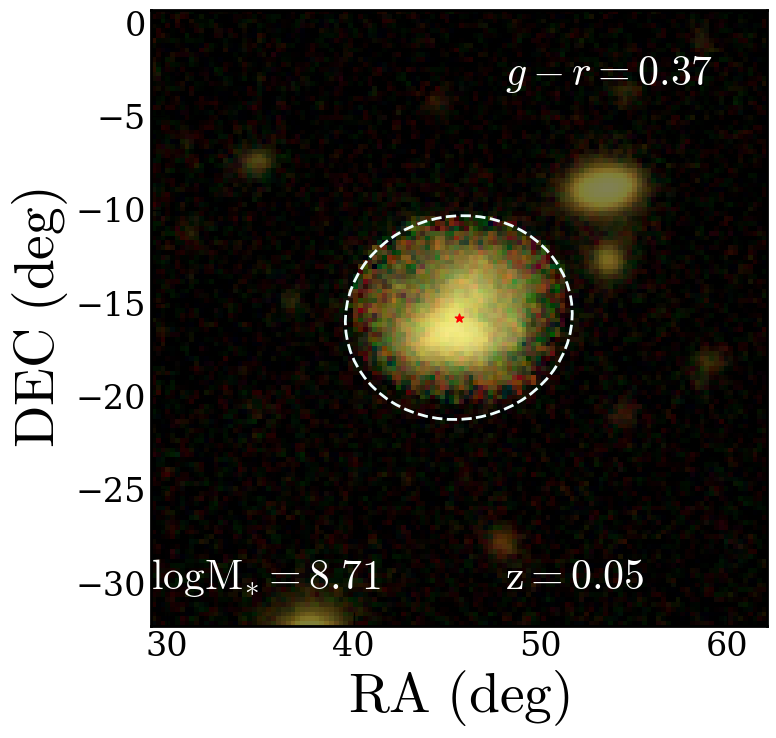

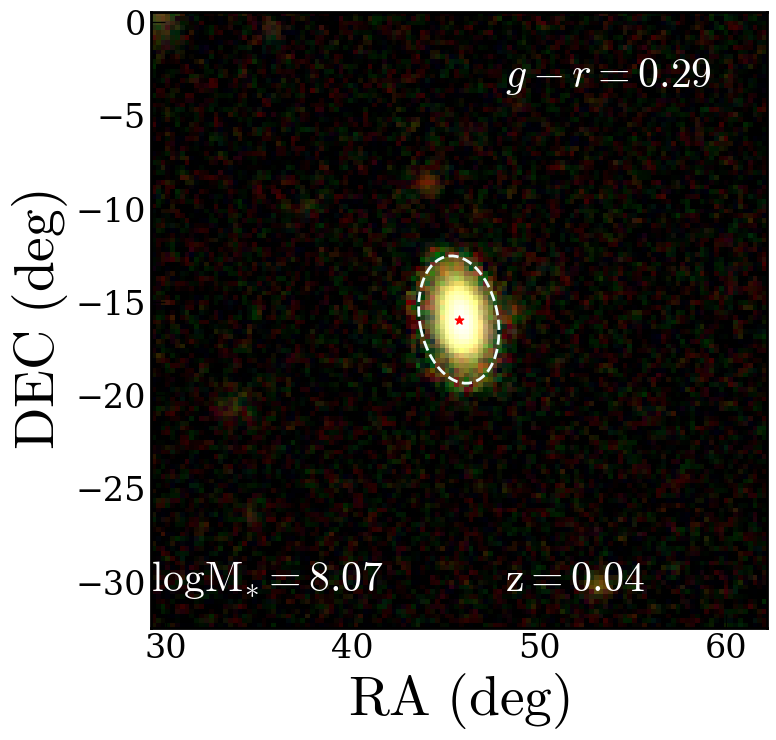

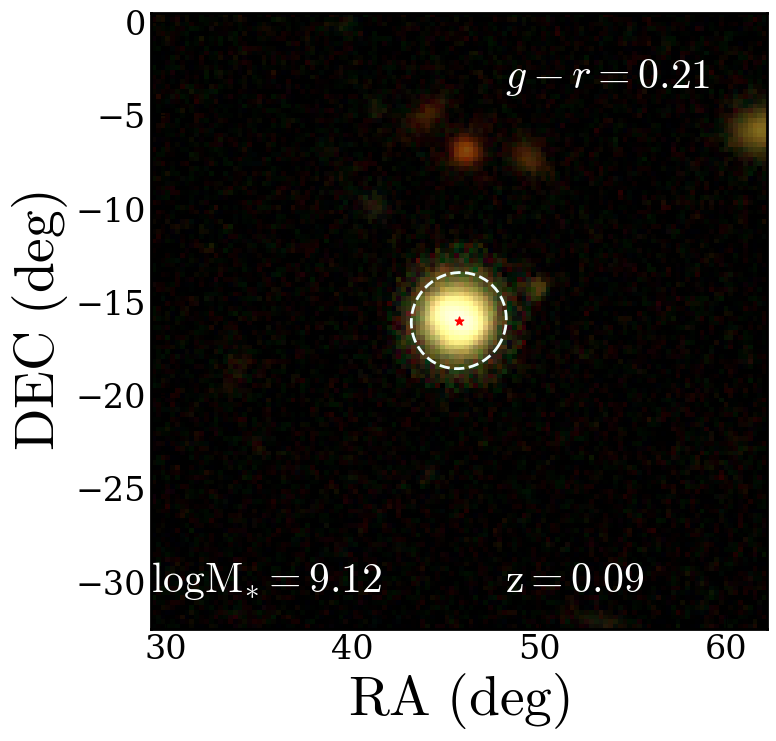

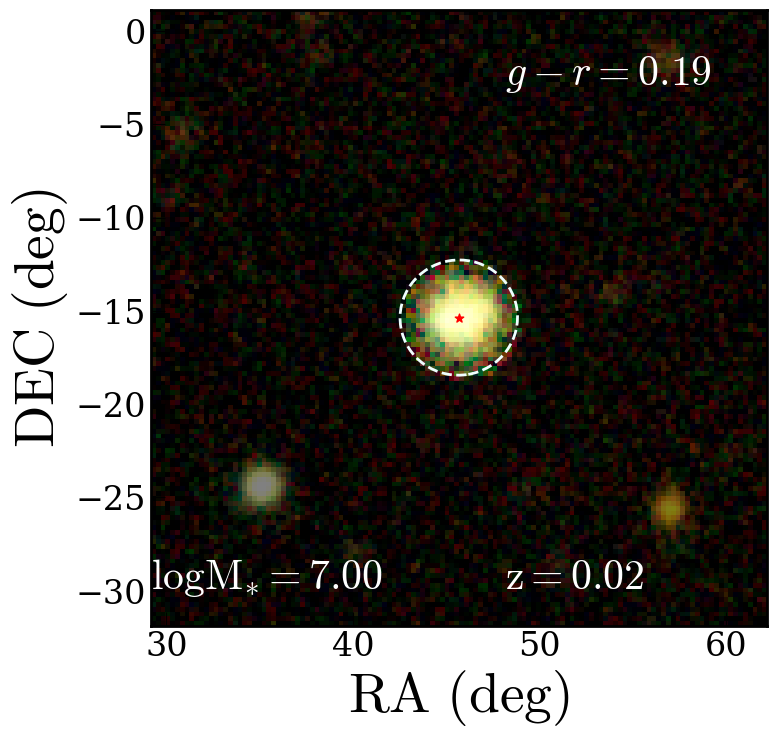

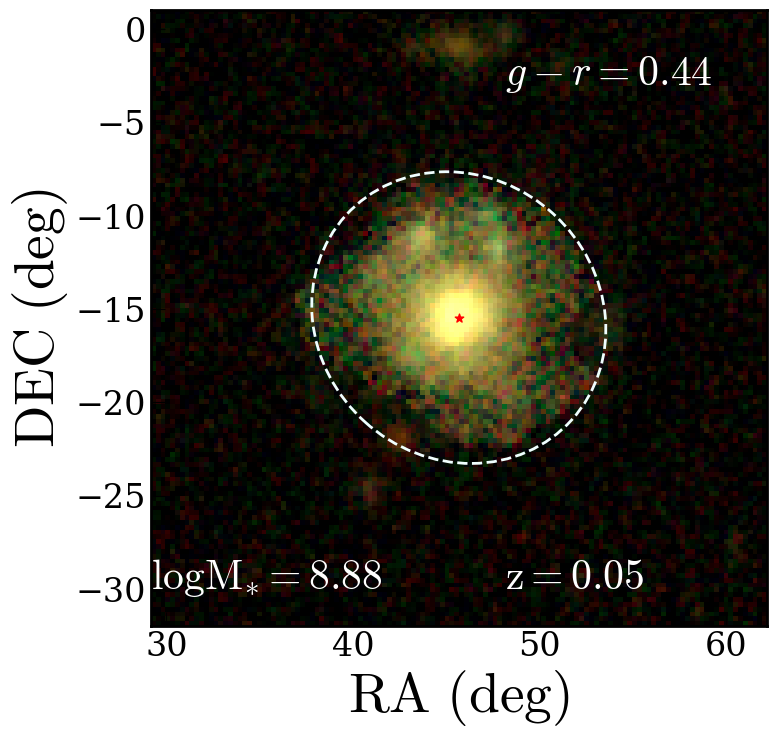

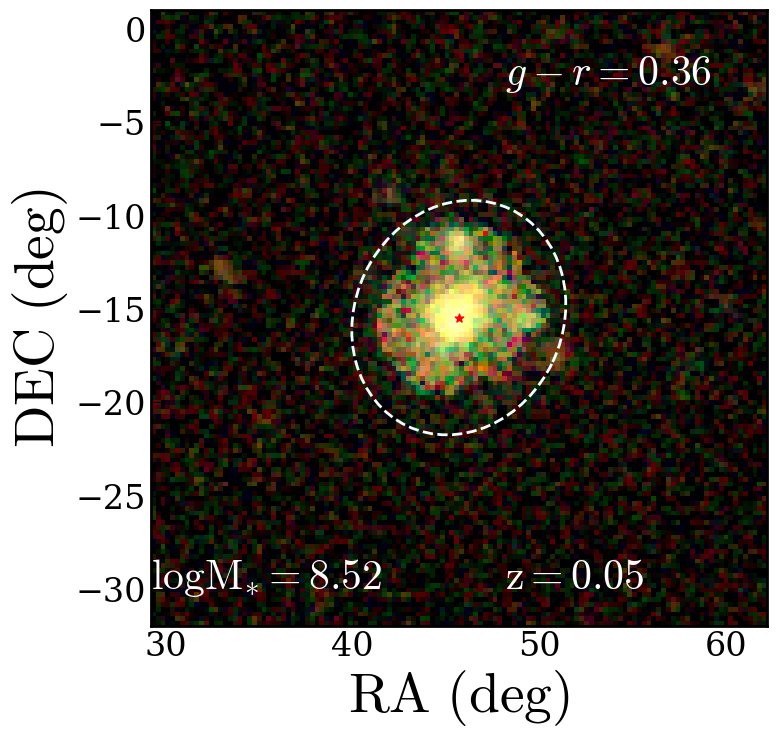

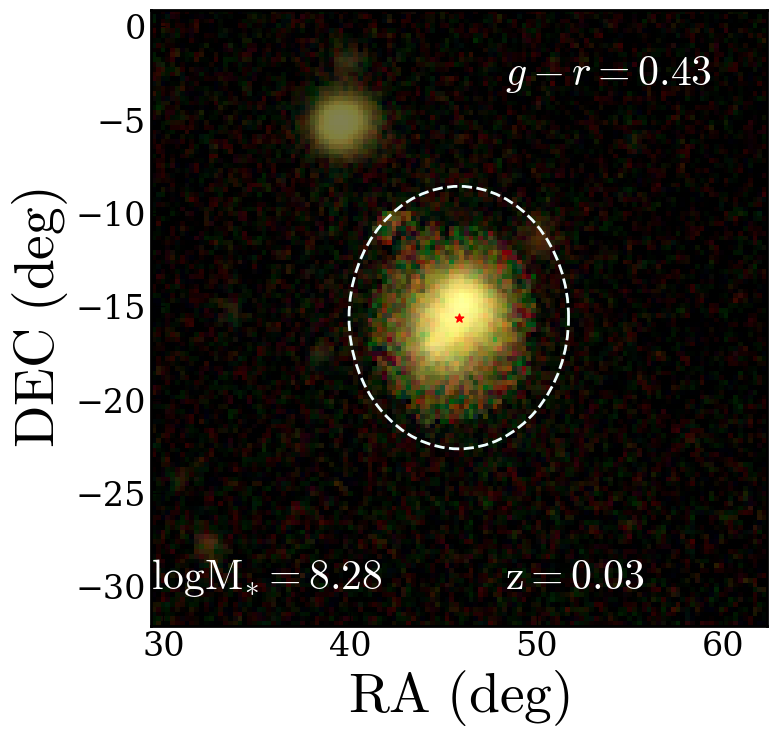

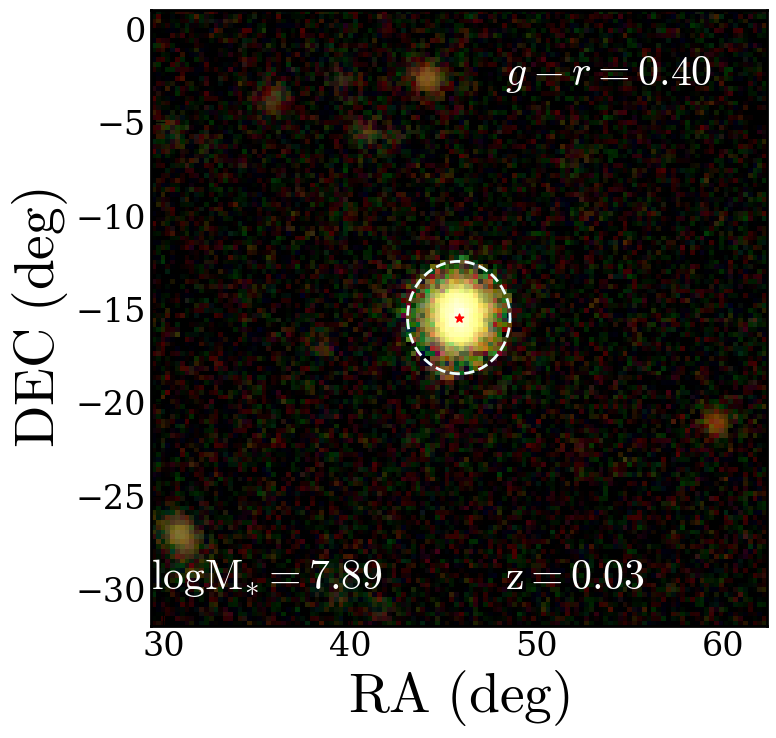

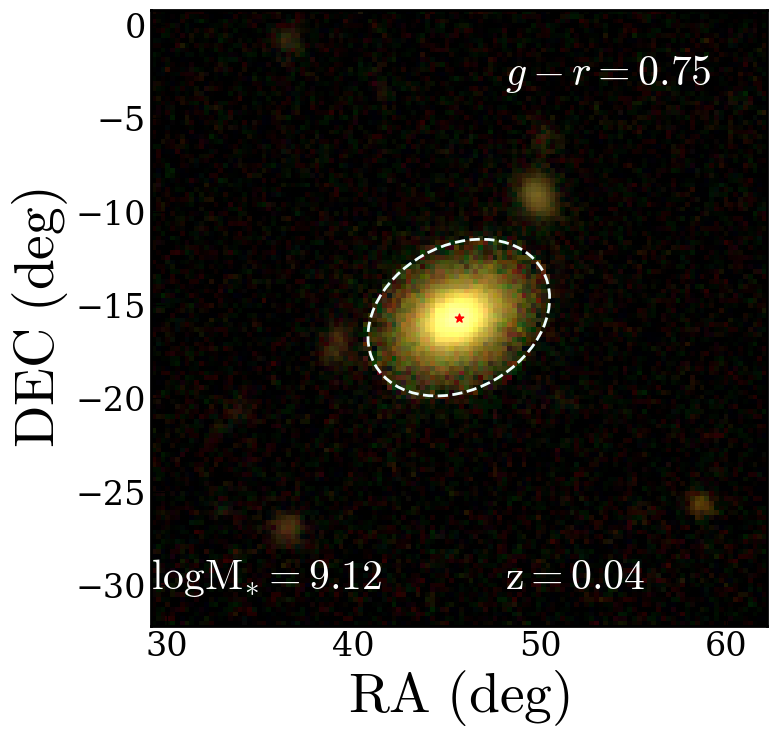

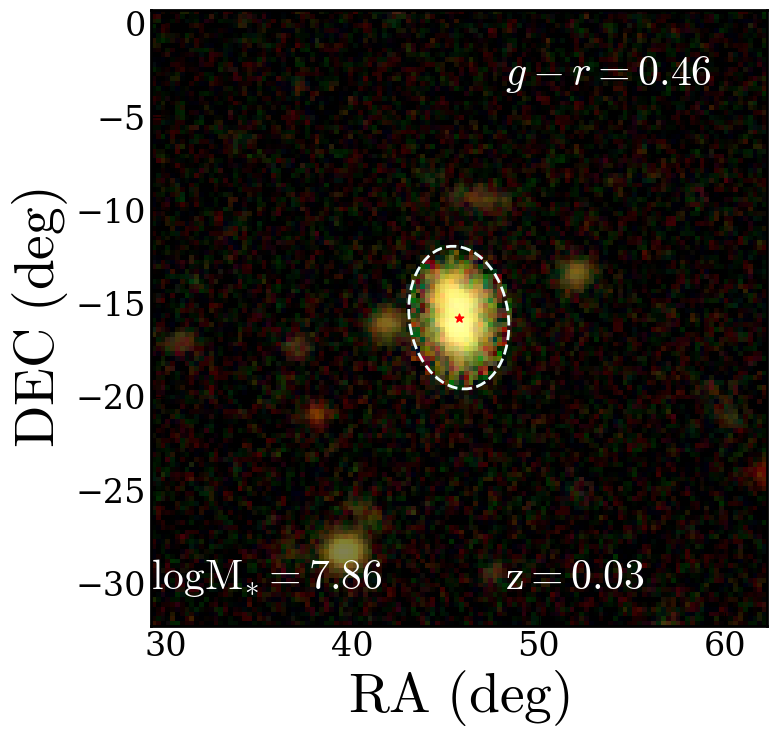

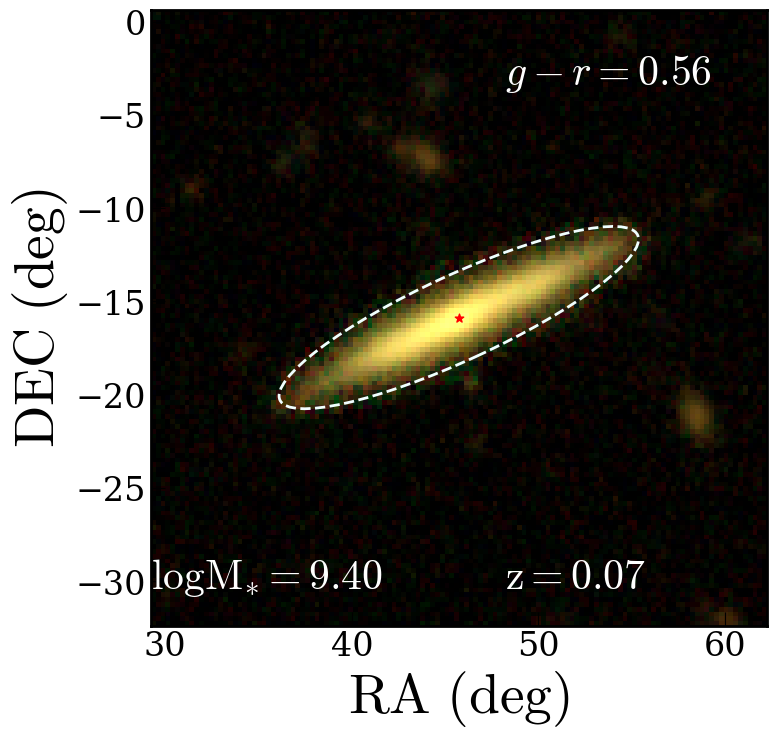

In [9]:
morph_par,petro_par,sersic_par = [],[],[]
imzer = np.zeros((128,128))
xx, yy = np.meshgrid(np.arange(0,128,1),np.arange(0,128,1))
#r_list = ptf.make_radius_list(max_pix=50,n=50)

t1 = time.time()

for ii,key in sources.iterrows():
        if ii<700 or ii>710: continue
        pos = np.array([key['ra'],key['dec']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))
        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)
        if (flags[0] or flags[1] or flags[3]): continue

        w = wcs.WCS(img_hdr,naxis=2)
        wc = [int(i) for i in w.world_to_pixel(pos_coord)]

        segmaps_lo,segmaps_hi = np.zeros((4,128,128)),np.zeros((4,128,128))
   
        for jj in range(4):
                if flags[jj]==True: continue
                #image_plot(ax[jj],img_data[jj],cmp=mcm.Greys)
                convolved_data = convolve(img_data[jj], model_psf)

                finder = SourceFinder(npixels=10, nlevels=32, contrast=0.0005, progress_bar=False)
                segment_map = finder(convolved_data, img_rms[jj])

                if segment_map==None: 
                    flags[jj]==True
                    continue
        
                cat = SourceCatalog(img_data[jj], segment_map, convolved_data=convolved_data)
                tbl = cat.to_table()                    
                    
                target = np.argmin(np.sqrt((tbl['xcentroid']-wc[0])**2+(tbl['ycentroid']-wc[1])**2))
                segmaps_lo[jj] = (1*(segment_map==(target+1)))
                segmaps_hi[jj] = (1*((segment_map!=imzer)&(segment_map!=(target+1))))

                '''
                flux_arr, area_arr, error_arr = ptf.source_photometry(cat[target], img_data[jj], segment_map, r_list, error=img_rms[jj],bg_sub=False, plot=False,vmin=np.median(img_data[jj])-np.std(img_data[jj]),vmax=np.median(img_data[jj])+np.std(img_data[jj]))
                petr = ptf.Petrosian(r_list, area_arr, flux_arr, flux_err=error_arr)
                print("{:0.4f} ± {:0.4f} pix".format(petr.r_petrosian, petr.r_petrosian_err))
                '''


        if (flags[0] or flags[1]): continue

        comp_segmap = 1* (np.logical_and(segmaps_lo[0],segmaps_lo[1])&(np.logical_xor(segmaps_lo[2],flags[2])|np.logical_xor(segmaps_lo[3],flags[3])))
        comp_mask = 1* np.logical_or(np.logical_or(segmaps_hi[0],segmaps_hi[1]),np.logical_or(segmaps_hi[2],segmaps_hi[3]))

        if comp_segmap[63,63]<1: continue
        
        fig,ax=plt.subplots(figsize=(16,8))

        rgb_img = rgb_cutout(img_data)
        #ax.imshow(comp_segmap, origin='lower')
        #ax[0].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)
        
        morph_arr,petro_arr,sersic_arr = np.zeros((4,12)),np.zeros((4,5)),np.zeros((4,4))

        img_copy = [img_data[k].copy() for k in range(3)]
        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])

        for k in range(3): np.putmask(img_copy[k],~(comp_segmap.astype('bool')),0)

        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506],alpha=0.5)
        #ax.scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        for jj,k in enumerate(channels):
            if flags[jj]==True: continue
            obs_psf = psf_grid(d_psf=16,fwhm=key['psfsize_'+k]/0.262,psf_type='moffat')
            morph = statmorph.source_morphology(img_data[jj], comp_segmap, weightmap=img_rms[jj],mask=comp_mask.astype('bool'),psf=obs_psf)[0]

            morph_arr[jj,:-1] = ii,morph.gini,morph.m20,morph.gini_m20_bulge,morph.gini_m20_merger,morph.concentration,morph.asymmetry,morph.smoothness,morph.shape_asymmetry,morph.flag,morph.sn_per_pixel
            petro_arr[jj,:] = morph.xc_asymmetry,morph.yc_asymmetry,morph.rpetro_ellip,morph.orientation_asymmetry,morph.ellipticity_asymmetry

            x,y,th = xx-petro_arr[jj,0], yy-petro_arr[jj,1],petro_arr[jj,3] 
            zz = np.sqrt(np.square((x*np.cos(th)+y*np.sin(th))/petro_arr[jj,2]) + np.square((x*np.sin(th)-y*np.cos(th))/(petro_arr[jj,2]*(1-petro_arr[jj,4]))))
            morph_arr[jj,-1] = np.sum(1*((comp_segmap>0)))/np.sum(1*(zz<1))

            sersic_arr[jj,:] = morph.sersic_n,morph.sersic_rhalf,morph.sersic_ellip,morph.flag_sersic

            '''
                prior  = autoprior(image = img_data[jj], profile_type = 'sersic', mask=mask, sky_type = 'flat') 
                fitter = FitSingle(data=img_data[jj],rms=img_rms[jj],mask=mask,psf=obs_psf,prior=prior,loss_func=student_t_loss)
                map_params = fitter.find_MAP(rkey = PRNGKey(1000))
            '''

        pos_asymm = w.pixel_to_world_values(petro_arr[1,0], petro_arr[1,1])
        ax.scatter(pos_asymm[0], pos_asymm[1],marker='*',color='red',s=40,zorder=101)

        
        e = Ellipse(xy=[pos_asymm[0], pos_asymm[1]],width=2*petro_arr[1,2]*0.262, height=2*petro_arr[1,2]*(1-petro_arr[1,4])*0.262,
                angle=petro_arr[1,3] * 180/np.pi,lw=2, fill=False,color='azure',ls='--')
        ax.add_artist(e)
        
        ax.text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(key['logM']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]-14.5,r'$z ={0:.2f}$'.format(key['zspec']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(key['g-r']),fontsize=30,color='white')

        ax.set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax.set_ylabel(r'$DEC \ (deg)$',fontsize=40)

        plt.savefig('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]),bbox_inches='tight')
        #plt.show()
        
        morph_par.append(morph_arr)
        petro_par.append(petro_arr)
        sersic_par.append(sersic_arr)

t2= time.time()
print(t2-t1)

In [5]:
morph_all = np.array(morph_par)
print(np.shape(morph_all))

np.save("morph_array.npy", morph_all)

sersic_all = np.array(sersic_par)
print(np.shape(sersic_all))

np.save("sersic_array.npy", sersic_all)

petro_all = np.array(petro_par)
print(np.shape(petro_all))

np.save("petro_array.npy", petro_all)

(21, 4, 12)
(21, 4, 4)
(21, 4, 5)


In [45]:
morph_all = np.load('morph_array.npy')

21


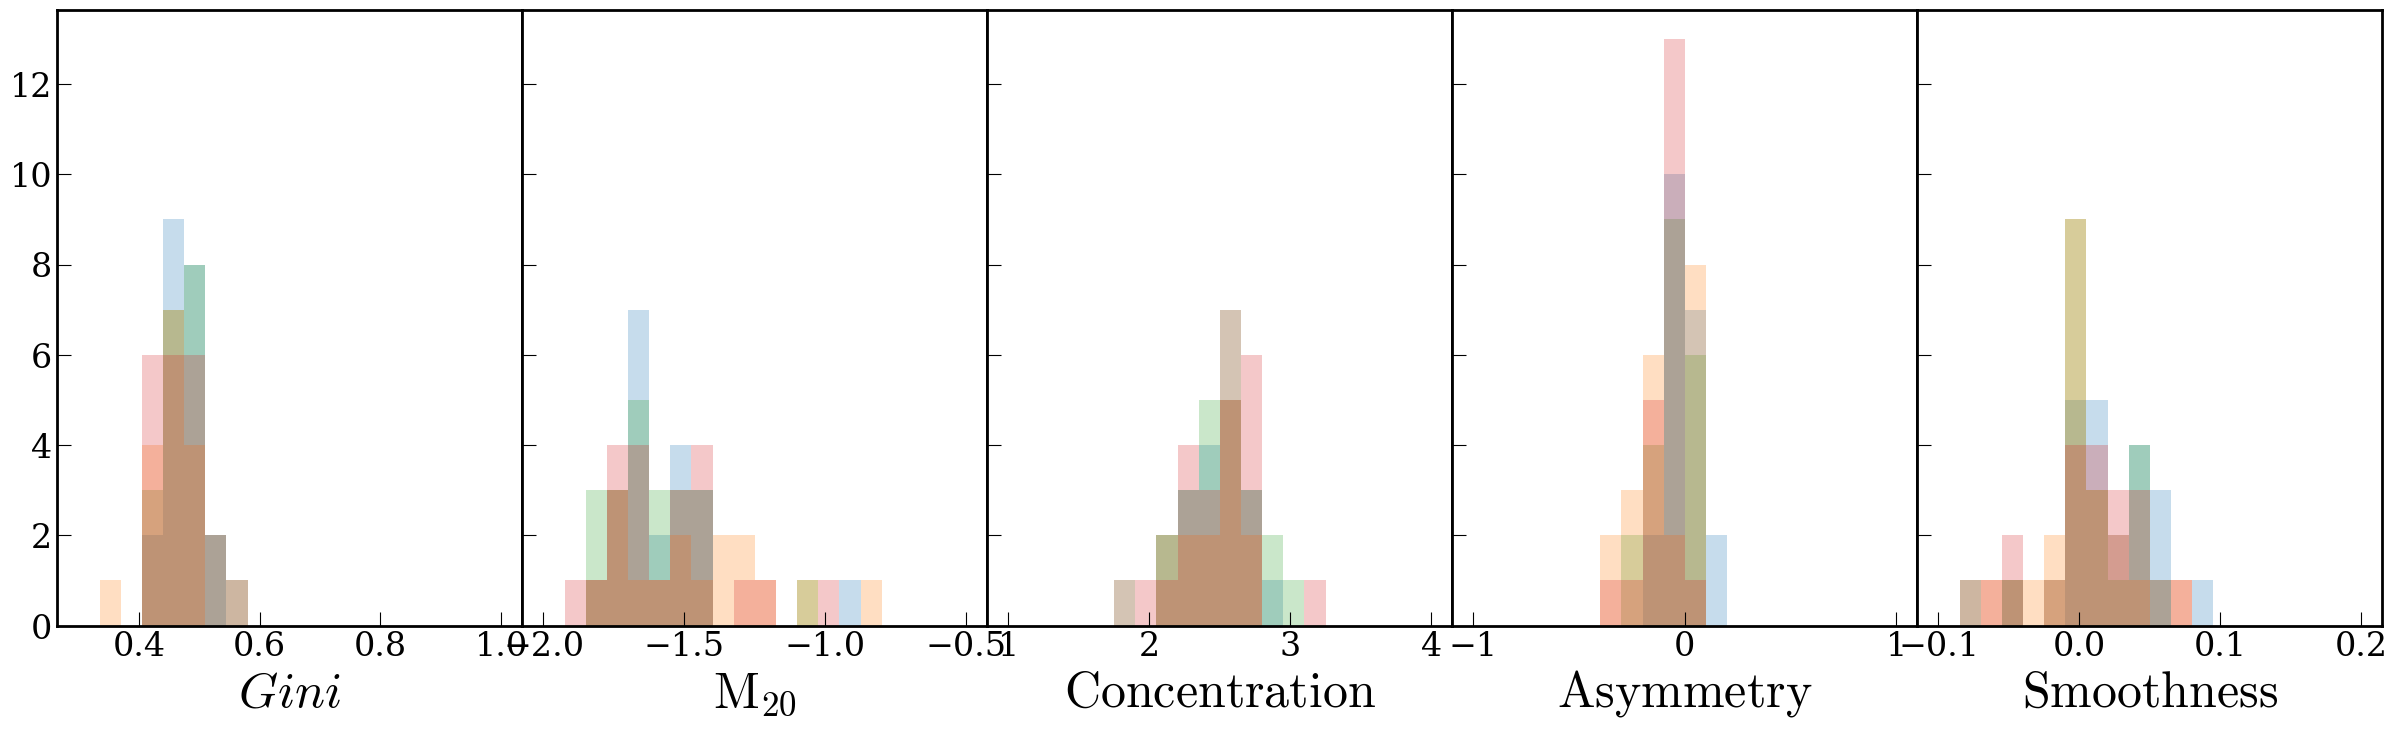

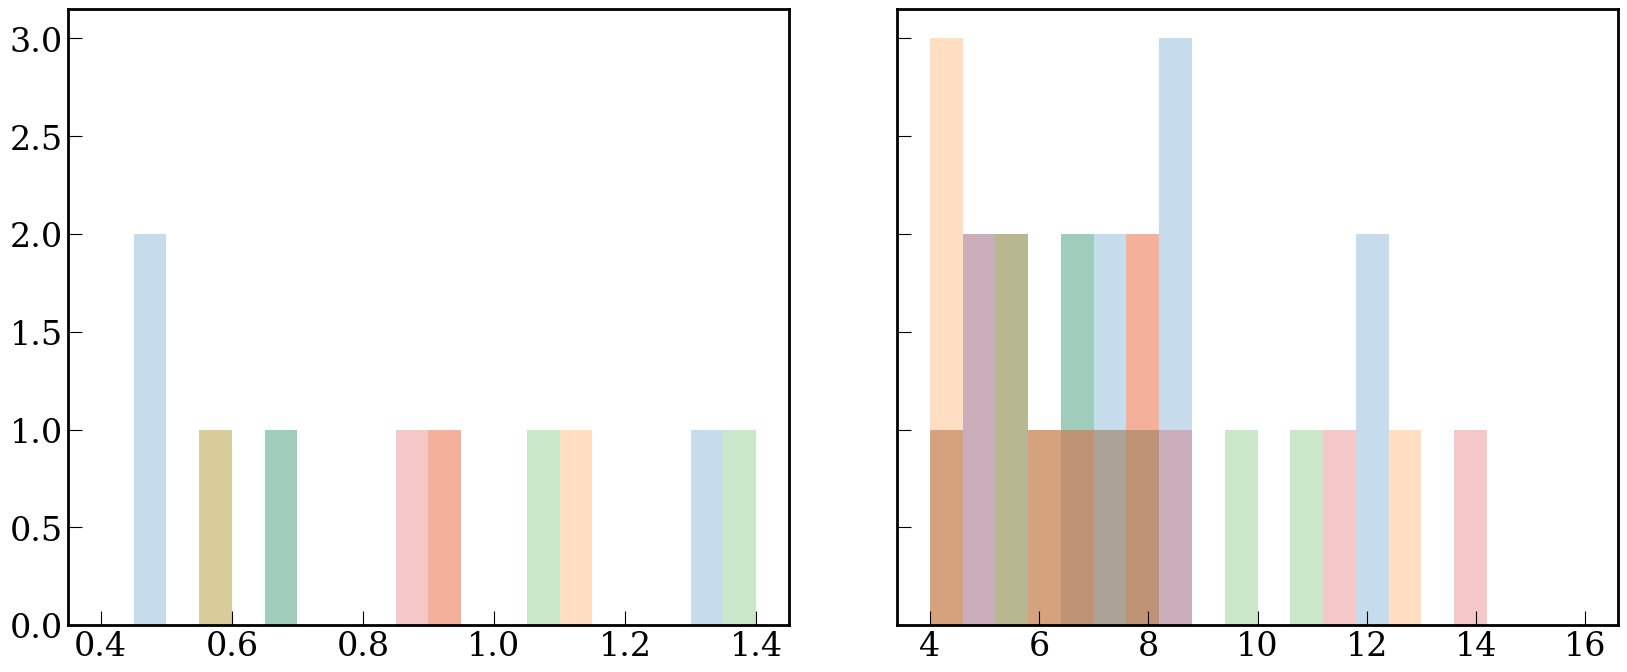

In [6]:
filt_cmap = [mcm.cividis_r,mcm.viridis_r,mcm.inferno_r,mcm.Greys]

high_snr = np.where((morph_all[:,0,10]>1)&(morph_all[:,1,10]>1))[0]
#high_snr = np.where((morph_all[:,0,9]<2)&(morph_all[:,0,9]>1))[0]
print(len(high_snr))


fig,ax=plt.subplots(1,5,figsize=(30,8),sharey=True)

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    #print(morph_arr[:,-1])
    ax[0].hist(morph_all[high_snr,i,1],bins=np.linspace(0.3,1.0,21),alpha=0.25,color=griz_col[i])
    ax[1].hist(morph_all[high_snr,i,2],bins=np.linspace(-2,-0.5,21),alpha=0.25,color=griz_col[i])
    ax[2].hist(morph_all[high_snr,i,5],bins=np.linspace(1,4,21),alpha=0.25,color=griz_col[i])
    ax[3].hist(morph_all[high_snr,i,6],bins=np.linspace(-1,1,21),alpha=0.25,color=griz_col[i])
    ax[4].hist(morph_all[high_snr,i,7],bins=np.linspace(-0.1,0.2,21),alpha=0.25,color=griz_col[i])

ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)
ax[1].set_xlabel(r'$M_{20}$',fontsize=36)
ax[2].set_xlabel(r'$Concentration$',fontsize=36)
ax[3].set_xlabel(r'$Asymmetry$',fontsize=36)
ax[4].set_xlabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0)
plt.savefig('NPdistributions.pdf',bbox_inches='tight')


fig1,ax1=plt.subplots(1,2,figsize=(20,8),sharey=True)


for i in range(4):
    ax1[0].hist(sersic_all[high_snr,i,0],bins=np.linspace(0.4,1.4,21),alpha=0.25,color=griz_col[i])
    ax1[1].hist(sersic_all[high_snr,i,1],bins=np.linspace(4,16,21),alpha=0.25,color=griz_col[i])
    
    #ax1[i].set_ylim((0.3,1.0))
    #ax1[i].set_xlim((-2,-0.5))
    #ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)


plt.subplots_adjust(wspace=0.15)
plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

47 47
47 47
47 47
47 47


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/_b/znph9d951ln009y69l1s4tn00000gn/T/ipykernel_57074/3978245827.py:25: SyntaxWarning: invalid escape sequence '\i'
  ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)


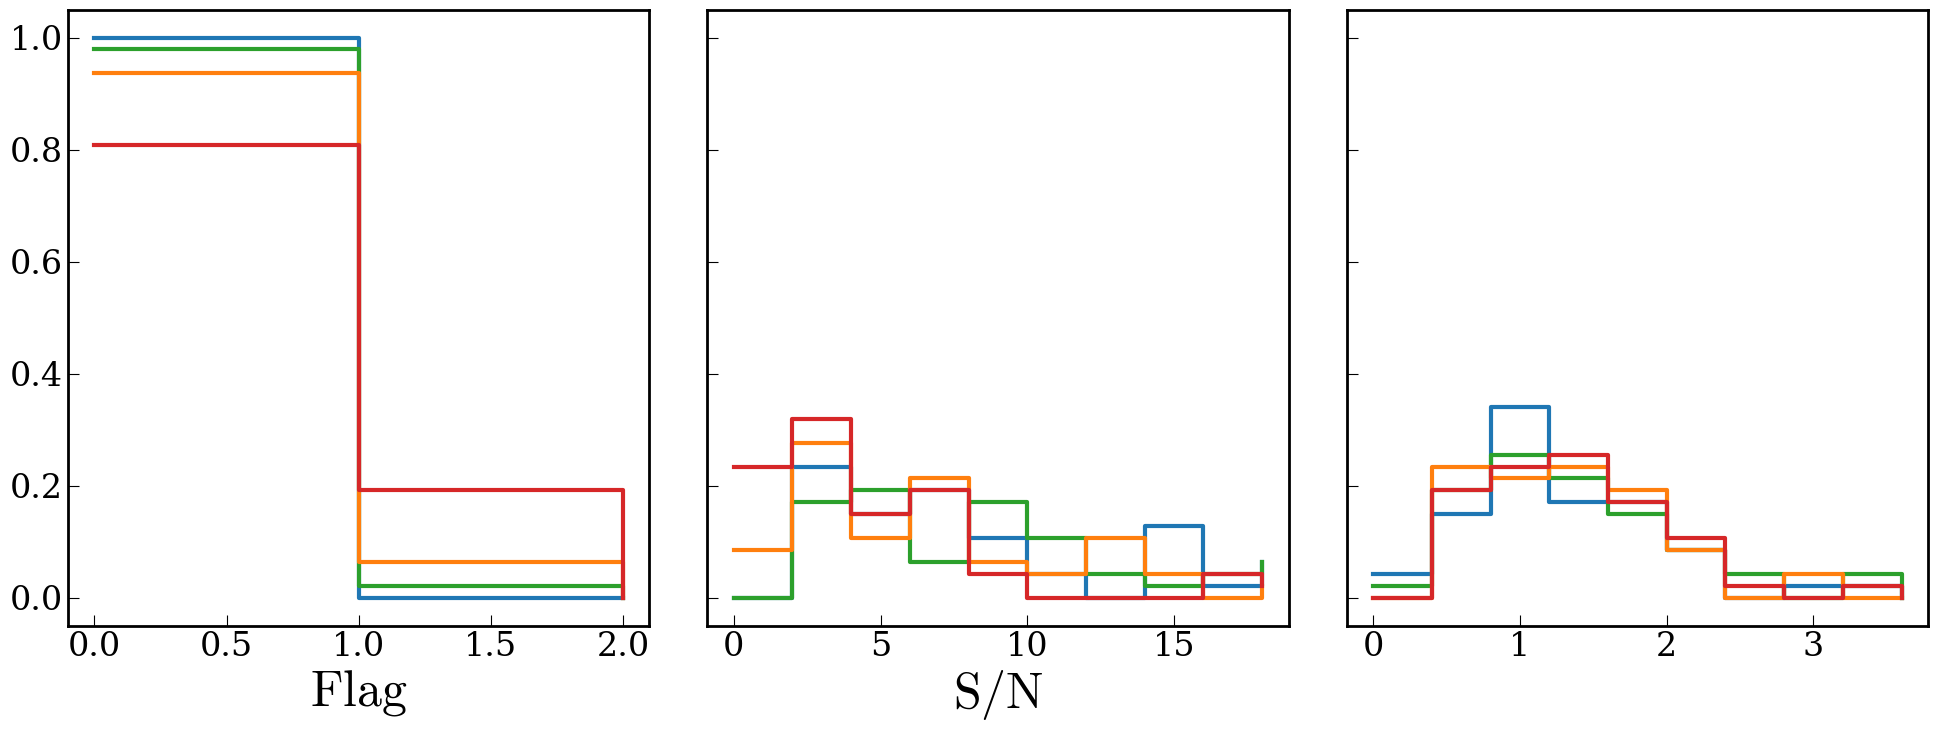

In [25]:
fig,ax=plt.subplots(1,3,figsize=(24,8),sharey='row')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    print(len(morph_all[:,i,9]),len(morph_all[:,i,10]))
    #print(morph_arr[:,-1])
    hist, bin_edg = np.histogram(morph_all[:,i,9], bins=np.arange(0,4,1))
    
    ax[0].step(bin_edg[:-1],hist/len(morph_all[:,i,9]),where='post',lw=3,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,10], bins=np.linspace(0,20,11))
    
    ax[1].step(bin_edg[:-1],hist/len(morph_all[:,i,10]),where='post',lw=3,color=griz_col[i])
    #ax[i,2].hist(morph_all[:,i,10],bins=np.linspace(0,1,26),alpha=0.4,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,11], bins=np.linspace(0,4,11))
    
    ax[2].step(bin_edg[:-1],hist/len(morph_all[:,i,11]),where='post',lw=3,color=griz_col[i])

ax[0].set_xlabel(r'${Flag}$',fontsize=36)
ax[1].set_xlabel(r'$S/N$',fontsize=36)
#ax[3,2].set_xlabel(r'$Segm\ Frac$',fontsize=36)
'''
ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)
ax[1].set_xlabel(r'$M_{20}$',fontsize=36)
ax[2].set_xlabel(r'$Concentration$',fontsize=36)
ax[3].set_xlabel(r'$Asymmetry$',fontsize=36)
ax[4].set_xlabel(r'$Smoothness$',fontsize=36)
'''
plt.subplots_adjust(hspace=0.0,wspace=0.1)
#plt.savefig('NPdistributions.pdf',bbox_inches='tight')

3243 [187.3702767  -2.0083458] 0.0829 9.431
g Background: 9.10700618987903e-05 g RMS^2: 1.5337418237793525e-06 g Var: 2.0148636e-06
r Background: 0.000367378699593246 r RMS^2: 1.7430398585116004e-05 r Var: 2.3255037e-05
i Background: 0.0008572903461754322 i RMS^2: 8.31495080459016e-05 i Var: 0.000111852336
z Background: 0.000441000796854496 z RMS^2: 9.21819326478307e-05 z Var: 0.00013463297
4473 [218.9849391   2.0838757] 0.09376 8.405
g Background: 9.120311005972326e-05 g RMS^2: 1.0981850616551773e-06 g Var: 1.2605151e-06
r Background: 0.0001902790681924671 r RMS^2: 3.7619419743402925e-06 r Var: 4.0683926e-06
i Background: 0.0003786060551647097 i RMS^2: 5.4023233722555464e-05 i Var: 6.5964006e-05
z Background: 9.39509118325077e-05 z RMS^2: 2.656673664426512e-05 z Var: 3.1624622e-05
4941 [321.3263601 -45.6765114] 0.07526 8.809
g Background: 1.3998112990520895e-05 g RMS^2: 1.6834355196518e-06 g Var: 2.6878174e-06
r Background: 7.284658931894228e-05 r RMS^2: 3.181516612795832e-06 r Var: 4

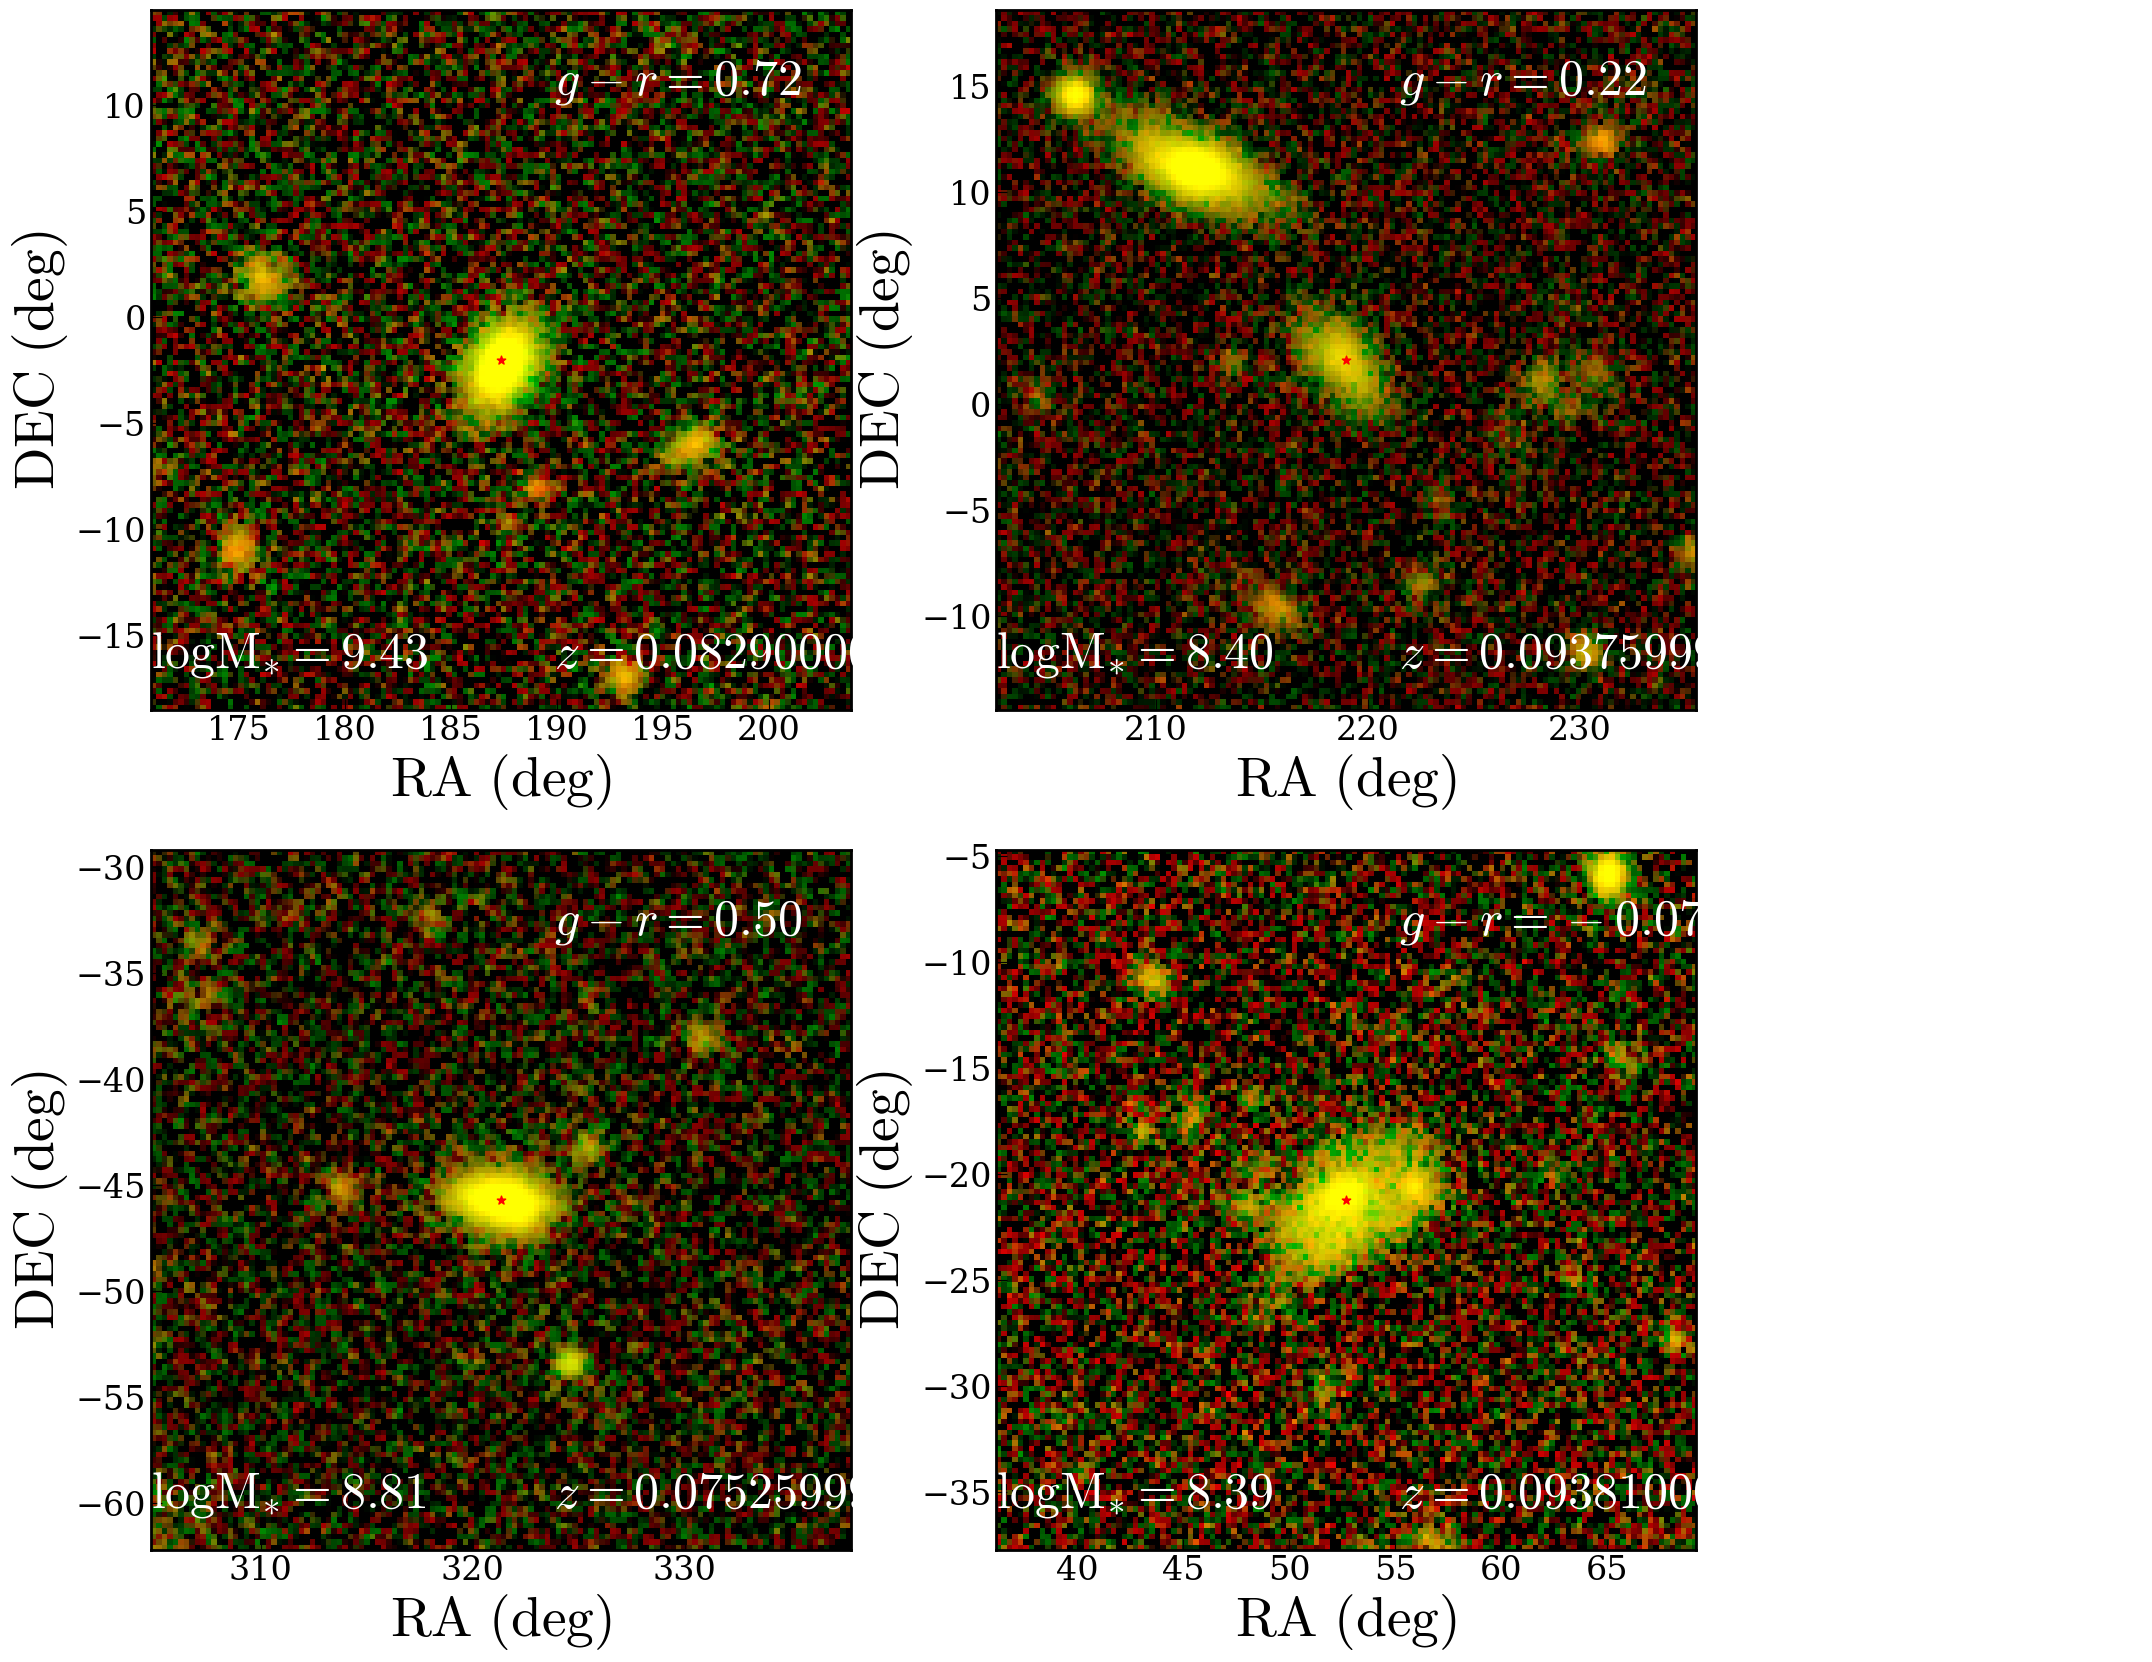

In [271]:
from astropy.convolution import convolve

four_sources = sources.sample(n=4)

fig,ax=plt.subplots(2,2,figsize=(20,20))

n=0
for ii,key in four_sources.iterrows():
        pos = np.array([key['RA'],key['DEC']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))

        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue
        #convolve(img_data[i], model_psf)

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)
        rgb_img = rgb_cutout(img_data)        
        ax[n//2,n%2].imshow(rgb_img, origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])
        ax[n//2,n%2].scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        
        ax[n//2,n%2].text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(key['logM']),fontsize=36,color='white')
        ax[n//2,n%2].text(pos[0]+2.5,pos[1]-14.5,r'${{\it z}} ={0:.24}$'.format(key['zspec']),fontsize=36,color='white')
        ax[n//2,n%2].text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(key['g-r']),fontsize=36,color='white')
        
        ax[n//2,n%2].set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax[n//2,n%2].set_ylabel(r'$DEC \ (deg)$',fontsize=40)

        n+=1

plt.savefig('SAGAbg_4samp.pdf',bbox_inches='tight')
plt.show()

In [ ]:
def image_bkg(img_dat,c=['g','r','i','z']):
    img_sub = []
    img_rms = []
    glob_rms = []

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header
    img_invvar = img_dat[1].data

    flags=[False]*4 


    w = wcs.WCS(img_hdr,naxis=2)
   
    for i,key in enumerate(channels):

        bkg = sep.Background(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')))
        var = np.reciprocal(img_invvar[i,:,:])
        
        print(key+' Background:',bkg.globalback,key+' RMS^2:',np.square(bkg.globalrms),key+' Var:',np.mean(var))
        glob_rms.append(bkg.globalrms)
                
        bkg_image,bkg_rms = bkg.back(),bkg.rms()
        
        img_sub.append(img_arr[i,:,:] - bkg_image)
        img_rms.append(np.sqrt(var))

        if np.mean(var)>100: flags[i]=True


    return np.stack(img_sub,0),img_hdr, np.stack(img_rms,0),glob_rms,flags

morph_par = []

for ii,key in sources.iterrows():
        if ii>10000: continue
        pos = np.array([key['RA'],key['DEC']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))

        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)

        if (flags[0] or flags[1] or flags[3]): continue
     
        #ns_pos = np.array([key['NS_RA'],key['NS_DEC']])
        #print(ns_pos)
        #get_star_psf(ns_pos

        #fig,ax=plt.subplots(1,4,figsize=(24,8),sharey=True)

        w = wcs.WCS(img_hdr,naxis=2)
        wc = [int(i) for i in w.world_to_pixel(pos_coord)]

        segmaps_hi,segmaps_lo = [],[]
        #n_obj = np.zeros(4)
        for jj in range(4):
                if flags[jj]==True: continue
                #image_plot(ax[jj],img_data[jj],cmp=mcm.Greys)
                objects,seg_map = sep.extract(img_data[jj], 1, err=img_rms[jj], segmentation_map=True,deblend_cont=0.0005,filter_type='matched',filter_kernel=model_psf)
                n_obj = len(objects['x'])
                if n_obj<1: 
                    flags[jj]==True
                    continue
                target = np.argmin(np.sqrt((objects['x']-wc[0])**2+(objects['y']-wc[1])**2))
                segmaps_lo.append(1*(seg_map==(target+1)))
                #print(hi_seg)

                objects,seg_map = sep.extract(img_data[jj], 4, err=img_rms[jj], segmentation_map=True,deblend_cont=0.001,filter_type='matched',filter_kernel=model_psf)
                n_obj = len(objects['x'])
                if n_obj<1: 
                    flags[jj]==True
                    continue
                target = np.argmin(np.sqrt((objects['x']-wc[0])**2+(objects['y']-wc[1])**2))
                segmaps_hi.append(1*(seg_map==(target+1)))

        if (flags[0] or flags[1] or flags[3]): continue

        if flags[2]==False: 
            comp_segmap = (segmaps_lo[0]&segmaps_lo[1])&(segmaps_lo[2]|segmaps_lo[3])&(segmaps_hi[0]&segmaps_hi[1])&(segmaps_hi[2]|segmaps_hi[3])
            all_segmap = (segmaps_lo[0]|segmaps_lo[1])|(segmaps_lo[2]|segmaps_lo[3])|(segmaps_hi[0]|segmaps_hi[1])|(segmaps_hi[2]|segmaps_hi[3])
        else: 
            comp_segmap = (segmaps_lo[0]&segmaps_lo[1])&(segmaps_lo[2])&(segmaps_hi[0]&segmaps_hi[1])&(segmaps_hi[2])
            all_segmap = (segmaps_lo[0]|segmaps_lo[1])|(segmaps_lo[2])|(segmaps_hi[0]&segmaps_hi[1])|(segmaps_hi[2])


        if comp_segmap[63,63]<1: continue
        
        fig,ax=plt.subplots(figsize=(16,8))

        rgb_img = rgb_cutout(img_data)
        #ax[0].imshow(rgb_img, origin='lower')
        #ax.imshow(comp_segmap, origin='lower')
        #ax[0].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)
        
        morph_arr = np.zeros((4,12))
        petro_arr = np.zeros((4,5))

        img_copy = [img_data[k].copy() for k in range(3)]
        for k in range(3): np.putmask(img_copy[k],~(comp_segmap.astype('bool')),0)

        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])
        #ax.scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        for jj in range(4):
            morph = statmorph.source_morphology(img_data[jj], comp_segmap, weightmap=img_rms[jj])[0]

            #snr = signal_to_noise(img_data[jj],img_rms[jj],comp_segmap)
            ar_petro2 = 4*np.pi*morph.rpetro_ellip*morph.rpetro_ellip*(1-morph.ellipticity_asymmetry)
            segmap_frac = np.sum(comp_segmap)/ar_petro2

            print(np.sum(comp_segmap),ar_petro2,segmap_frac)
            morph_arr[jj,:] = ii,morph.gini,morph.m20,morph.gini_m20_bulge,morph.gini_m20_merger,morph.concentration,morph.asymmetry,morph.smoothness,morph.shape_asymmetry,morph.flag,morph.sn_per_pixel,segmap_frac
            petro_arr[jj,:] = morph.xc_asymmetry,morph.yc_asymmetry,morph.rpetro_ellip,morph.orientation_asymmetry,morph.ellipticity_asymmetry

            #in_petro = np.where(comp_segmap>0)
            #rd_petro = np.square((in_petro[0]-morph.xc_asymmetry)/morph.rpetro_ellip)+np.square((in_petro[1]-morph.yc_asymmetry)/(morph.rpetro_ellip*(1-morph.ellipticity_asymmetry)))
            #print(len(np.where(rd_petro<4)[0])/ar_petro2)

        pos_asymm = w.pixel_to_world_values(petro_arr[1,0], petro_arr[1,1])
        ax.scatter(pos_asymm[0], pos_asymm[1],marker='*',color='red',s=40,zorder=101)

        for l in [1,2]:
            e = Ellipse(xy=[pos_asymm[0], pos_asymm[1]],
                width=l*petro_arr[1,2]*0.262, height=l*petro_arr[1,2]*(1-petro_arr[1,4])*0.262,
                angle=petro_arr[1,3] * 180/np.pi,lw=2, fill=False,color='azure',ls='--')
            ax.add_artist(e)
        ax.text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(key['logM']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]-14.5,r'$z ={0:.2f}$'.format(key['zspec']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(key['g-r']),fontsize=30,color='white')

        ax.set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax.set_ylabel(r'$DEC \ (deg)$',fontsize=40)

    
        plt.savefig('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]),bbox_inches='tight')
        #plt.show()

        morph_par.append(morph_arr)


In [ ]:


fig1,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)

hdex = [-2.0,-0.5,0.3,1.0]

M20_arr = np.linspace(-2,-0.5,11)
M20_arrhalf = np.linspace(-2,-1.68,11)


for i in range(4):

    mst = sources['SERSIC'].iloc[morph_all[high_snr,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])

    #non_merg = high_snr[np.where(morph_all[high_snr,i,1]<np.minimum(hubble_line(morph_all[high_snr,i,2]),merger_line(morph_all[high_snr,i,2])) )[0]]
    #med_m20,med_gini = np.median(morph_all[non_merg,i,2]),np.median(morph_all[non_merg,i,1])
    #print(med_m20,med_gini)

    hss_arr = hess_arr(morph_all[high_snr,i,2],morph_all[high_snr,i,1],1.0,hdex,80)
    #print(np.sum(hss_arr[j,:,:] ),np.amax(hss_arr[j,:,:] ),np.amin(hss_arr[j,:,:] ))
    ax1[i].imshow(hss_arr,cmap='viridis',aspect='auto',extent = hdex,origin='lower',interpolation='gaussian',norm=mcol.LogNorm(vmax=np.amax(hss_arr),vmin=1e-6))

    #ax1[i].scatter(morph_all[high_snr,i,2]-med_m20,morph_all[high_snr,i,1]-med_gini,c=mst,s=120,cmap=filt_cmap[i],vmin=0.5,vmax=3.5,edgecolors='black')

    #ax1[i].set_ylim((-0.1,0.5))
    #ax1[i].set_xlim((-0.5,1.5))
    ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)


ax1[0].set_ylabel( r'${\it Gini}$',fontsize=40)